# Fig4a - cumulative repeat frequency of proteins - RADAR 



In [172]:
## Using the RADAR package to do denovo identification of repeat sequences
## Whole proteome run through this program 
# radar.py -a PlasmoDB-33_Pfalciparum3D7_AnnotatedProteins.known.A.fasta > RADAR_3D7proteins_full.txt
# radar.py -a PlasmoDB-33_PfalciparumIT_AnnotatedProteins.known.A.fasta > RADAR_ITproteins.txt


## This code is to parse the details of repeats for all the proteins and store in a dictionary 
from collections import defaultdict 

fh = open('RADAR_3D7proteins_full.txt','r',encoding = "ISO-8859-1")
dict_radar_3D7 = defaultdict(dict)
dict_cumulative_radar_3D7 = defaultdict(int)

for line in fh:
    if line[0] == '>': ## if it is the fasta header name, collect the protein name 
        protein = line.strip('\n').lstrip('>')
    elif line[0:16] == 'No repeats found':
        dict_cumulative_radar_3D7[protein] = 0
    elif line[0:14] == 'No. of Repeats':
        items = next(fh).split("|") ## get the items from the next list 
        number = items[0].strip(' ').lstrip(' ')
        length = items[2].strip(' ').lstrip(' ')
        if length in dict_radar_3D7[protein].keys():
            dict_radar_3D7[protein][length].append(number)
        else:
            dict_radar_3D7[protein][length] = [number]

        
        dict_cumulative_radar_3D7[protein] = dict_cumulative_radar_3D7[protein] + int(number)
        
    else:
        continue 
fh.close()


fh = open('RADAR_IT_proteins.txt','r',encoding = "ISO-8859-1")
dict_radar_IT = defaultdict(dict)
dict_cumulative_radar_IT = defaultdict(int)

for line in fh:
    if line[0] == '>': ## if it is the fasta header name, collect the protein name 
        protein = line.strip('\n').lstrip('>')
    elif line[0:16] == 'No repeats found':
        dict_cumulative_radar_IT[protein] = 0
        
    elif line[0:14] == 'No. of Repeats':
        items = next(fh).split("|") ## get the items from the next list 
        number = items[0].strip(' ').lstrip(' ')
        length = items[2].strip(' ').lstrip(' ')
        if length in dict_radar_IT[protein].keys():
            dict_radar_IT[protein][length].append(number)
        else:
            dict_radar_IT[protein][length] = [number]

        
        dict_cumulative_radar_IT[protein] = dict_cumulative_radar_IT[protein] + int(number)
        
    else:
        continue 
fh.close()

dict_cumulative_radar = {**dict_cumulative_radar_3D7, **dict_cumulative_radar_IT} 



In [175]:
## Collecting hit and non-hit proteins

## Hit proteins - are the unique, non-VSA proteins from 3D7 and IT
## Non-hit proteins - are 3D7 non-hit, non-VSA proteins. 3D7 orhtologs of IT hits that are uniquee are also subtracted from this list  
## This collection has only 3D7 versions to avoid duplicate samplinng 
import random 
import re 

fh192 = open('Hits_zscore_3_cmin5_alluniquegenehits_nonVSA.txt','r')
    
hits_zhit3_3D7_IT_proteins = set()

for line in fh192:
    if ('PF3D7' in line) | ('PFIT' in line):  ### don't add VSAs
        hits_zhit3_3D7_IT_proteins.add(line.strip('\n')+'.1-p1') ## only add one protein isoform per gene 
fh192.close()


## Hit proteins - are the unique, non-VSA proteins from 3D7 and IT
hit_list = list(hits_zhit3_3D7_IT_proteins.intersection(dict_cumulative_radar.keys()))
print ("The number of ubique 3D7 + IT hits us " + str(len(hit_list)))

## Non-hit proteins - are 3D7 non-hit, non-VSA proteins. 3D7 orhtologs of IT hits that are uniquee are also subtracted from this list  
## This collection has only 3D7 versions to avoid duplicate samplinng 


### Remove 3D7 VSAs from dict_cumulative_radar 

fh = open('PlasmoDB-33_Pfalciparum3D7_AnnotatedProteins.known.A.fasta','r')

set_VSA = set()

for line in fh:
    if line[0] == '>':
        protein = line[1:].strip('\n')
        
        if any(re.findall(r'rifin|RIFIN|Rifin|PfEMP1|PFEMP1|pfemp1|erythrocyte_membrane_protein_1|stevor|Stevor|STEVOR|SURFIN|surfin|Surfin|Pfmc-2TM|pfmc-2TM',protein)):
            set_VSA.add(protein.split("|")[0].strip(' '))

fh.close()

print ("The number of VSAs " + str(len(set_VSA)))


# 3D7 orhtologs of IT hits that are uniquee

fh11 = open("3D7_homologs_of_IThits_Z3cmin5.txt","r")
fh11.readline()

set_3D7_ortholog_ofIT = set()

for line in fh11:
    item = line.strip("\n").split("\t")
    gene = item[0]+'.1-p1'
    set_3D7_ortholog_ofIT.add(gene)
fh11.close()   

print ("The number of 3D7 orthologs that the  IT genes corresponded to is " + str(len(set_3D7_ortholog_ofIT)))


## Non-hit proteins - are non-hit, non-VSA proteins from 3D7 (didn't include IT to keep this unique) 
non_hits = dict_cumulative_radar_3D7.keys()-hits_zhit3_3D7_IT_proteins - set_3D7_ortholog_ofIT - set_VSA 
print ("The number of non-hit, non-VSA proteins that remove both 3D7 and IT unique hits is " + str(len(non_hits)))






The number of ubique 3D7 + IT hits us 1636
The number of VSAs 274
The number of 3D7 orthologs that the  IT genes corresponded to is 798
The number of non-hit, non-VSA proteins that remove both 3D7 and IT unique hits is 3448


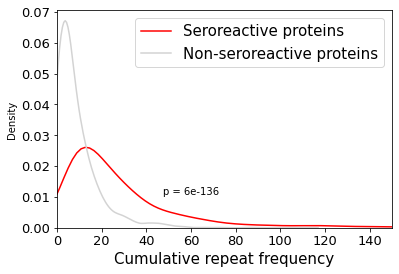

In [41]:
### Random sampling from the non-hit pool 
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 
import random 

randomsample = random.sample(list(non_hits),1636) 

A = [dict_cumulative_radar[x] for x in hit_list]
A_random = [dict_cumulative_radar[x] for x in randomsample]

fig, ax = plt.subplots()
# sns.histplot((A),color='red',label= 'Seroreactive proteins',stat='probability')
# sns.histplot((A_random),color='lightgrey',label = 'Non-seroreactive proteins',stat='probability')
sns.kdeplot((A),color='red',label= 'Seroreactive proteins')
sns.kdeplot((A_random),color='lightgrey',label = 'Non-seroreactive proteins')
ax.set_xlabel('Cumulative repeat frequency',size=15)
ax.tick_params(labelsize =13)
#ax.set_xticklabels(['0','1','4','16','64','256'],size=13)
#ax.set_ylim(0,1)
ax.set_xlim(0,150)
#ax.set_ylabel('Number of proteins',size=15)
plt.legend( loc='upper right',prop={'size': 15})

## p-value for significance of difference between the two distributions 
from statistics import median
import scipy 
pvalue = []
# Bootstrap random sampling 1000 times and get the max p-value 
median_random = []
for i in range(0,1000):
    randomsample = random.sample(list(non_hits),1636)
    A = [dict_cumulative_radar[x] for x in hit_list]
    A_random = [dict_cumulative_radar[x] for x in randomsample]
    median_random.append((median(A_random)))
    pvalue.append(scipy.stats.ks_2samp(A,A_random)[1]) 

maxp = max(pvalue)

ax.text(x=60,y=0.01, s= 'p = ' + "%.1g" % (maxp), ha='center', va='bottom')
# plt.savefig('Fig4a.pdf', dpi=800)

plt.show()

    

In [178]:
from statistics import median 
randomsample = random.sample(list(non_hits),1636) 

A = [dict_cumulative_radar[x] for x in hit_list]
A_random = [dict_cumulative_radar[x] for x in randomsample]


print (median(A))
print (median(A_random))


20.0
6.0


# Fig 4c


## conservative subs encoding 

In [ ]:


from collections import defaultdict
import regex as regex
import json

# The below two files can be obtained from the Dryad dataset 

fh1 = open('PlasmoDB-33_Pfalciparum3D7_AnnotatedProteins.known.A.fasta','r')
fh2 =  open('PlasmoDB-33_PfalciparumIT_AnnotatedProteins.known.A.fasta','r')


dict_3D7_IT_proteins = {}
dict_prot_allmotifs = defaultdict(dict)
dict_prot_highestmotif = {}

for line in fh1:
    if line[0] == '>':
        name = line[1:].split('|')[0].strip(' ')
        sequence = fh1.readline().strip('\n')
        dict_3D7_IT_proteins[name] = sequence
fh1.close()

for line in fh2:
    if line[0] == '>':
        name = line[1:].split('|')[0].strip(' ')
        sequence = fh2.readline().strip('\n')
        dict_3D7_IT_proteins[name] = sequence
fh2.close()

print (len(dict_3D7_IT_proteins))


dayhoff = {'C':'a',
           'G':'b',
           'A':'b',
           'P':'p',
           'S':'s',
           'T':'s',
           'D':'c',
           'E':'c',
           'N':'n',
           'Q':'n',
           'R':'d',
           'H':'d',
           'K':'d',
           'L':'e',
           'V':'e',
           'I':'e',
           'M':'m',
           'Y':'f',
           'F':'f',
           'W':'f',
           'X':'x' }

dict_3D7_IT_proteins_dayhoff = {}

for protein in dict_3D7_IT_proteins:
    seq = dict_3D7_IT_proteins[protein]
    dayseq = ''
    for aa in seq:
        day = dayhoff[aa]
        dayseq = dayseq+day
    dict_3D7_IT_proteins_dayhoff[protein] = dayseq


dict_protein_kmer = defaultdict(dict)
hj=0
for key,sequence in dict_3D7_IT_proteins_dayhoff.items():
    hj=hj+1
   
    protein = key
    sequence = sequence.strip('\n')   
    kmer_freq = defaultdict(int) ## initial set of kmer freq dictionary for each protein 
    for i in range (0,len(sequence)-6): ### loop until the end of the protein seq and add the freq of all 7-mers within protein 
        sevenmer = sequence[i:i+7]
        if ((sevenmer != 'nnnnnnn') & (sevenmer != 'ccccccc') & (sevenmer != 'ddddddd')): ## don't include polystretches 
            if sevenmer in kmer_freq:

                kmer_freq[sevenmer] = kmer_freq[sevenmer] + 1
            else:
                kmer_freq[sevenmer] = 1 
    
    ### Remove overlapping matches and report only non-overlapping repeat number 
    
    for kmer in kmer_freq: 
        nonoverlapfreq = sequence.count(kmer)
        kmer_freq[kmer] = nonoverlapfreq

    
    dict_protein_kmer[protein] = kmer_freq
    
    

## repeat index of peptide calculation 

In [43]:
### Looking at HIT peptides vs NON-HIT peptides 

### ALL FALC NON-VSA PEPTIDES 

## Get the list of all peptides. Filter for those that are from falciparum (PF3D7 and PFIT genes)
## Remove genes that correrspond to the gene family of PfEMP1, RIFIN, STEVOR 

## HIT PEPTIDES 

### Get the list of unique HIT proteins - these refer to those that are not repeated as both 3D7 and IT (only one ortholog represented if both are in the pool)
### Multiple isoforms from a single gene are not multiply counted - only one is counted 
### Sequences corresponding to these are used for this analysis 

## NON-HIT PEPTIDES FROM ALL NON-VSA PROTEINS 

## Peptides in the rest of the peptide pool corresponding to unique proteins and peptides that are not from the hit set
## These don't have sequences from PfEMP1, RIFIN, STEVOR 

## NON-HIT PEPTIDES FROM HIT PROTEINS 

## Non-hit peptides from non-VSA hit proteins 


import pandas as pd 

z_hit_3 = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv',header=0,index_col = 'peptide')


### combine the peptides with their sequence                   

#1. Read peptide fasta a file. Make a dictionary of peptide names with sequences and convert to a df 

## Modify the code below accordingly to capture peptide name and sequence if working with Whole_library_peptide_to_gene_mapping.csv file from Dryad instead of FinalPlasmodiumFalciparumPhagePeptides.v2.fa

fh2 = open('FinalPlasmodiumFalciparumPhagePeptides.v2.fa','r') 


seq = {}
for line in fh2: 
    name = line.strip("\n")[1:] ## don't include the '>' symbol at the beginning
    name = name.replace(",", "_") ## some peptidees have a , in the file, but _ in the dataset
    sequence = fh2.readline()
    if ('PF3D7' in name) | ('PFIT' in name):  ### collect only peptides that are only PF and that too non-VSA 
        seq[name] = sequence

df_peptide_fasta = pd.DataFrame.from_dict(seq, orient='index')
df_peptide_fasta.columns = ['sequence']
fh2.close()


print ("The total library size with PF3D7/PFIT seq is " + str(df_peptide_fasta.shape[0]))


### Remove non-VSAs (PFEMP1, RIFIN, SURFIN and STEVORs from this collection 

df_peptide_nonVSA_fasta = df_peptide_fasta.drop((df_peptide_fasta.filter(regex='PfEMP1|PFEMP1|pfemp1|erythrocyte_membrane_protein_1|stevor|Stevor|STEVOR|rifin|RIFIN|Rifin|SURFIN|surfin|Surfin',axis=0).index),axis=0)

print ("The total library size with PF3D7/PFIT seq and dropping PFEMP1, RIFIN, STEVOR and SURFIN is " + str(df_peptide_nonVSA_fasta.shape[0]))

#### Collect ALL the HIT peptides corresponding to only unique HIT GENES 
fh192 = open('Hits_zscore_3_cmin5_alluniquegenehits_nonVSA.txt','r')
    
hits_zhit3_3D7_IT_proteins = set()

for line in fh192:
    if ('PF3D7' in line) | ('PFIT' in line):  ### don't add VSAs
        hits_zhit3_3D7_IT_proteins.add(line.strip('\n')+'.1-p1') ## only add one protein isoform per gene 
fh192.close()

print ("The total number of unique protein hits (with no orthologs/non VSA) is " +str(len(hits_zhit3_3D7_IT_proteins)))

to_search = '|'.join(hits_zhit3_3D7_IT_proteins)

## Collect the HIT peptides from unique genes

df_peptide_fasta_HIT_peptides =  pd.merge(z_hit_3.filter(regex = to_search ,axis=0),df_peptide_nonVSA_fasta,left_index=True,right_index=True)
print ("The total number HIT peptides from unique non-VSA proteins is " + str(df_peptide_fasta_HIT_peptides.shape[0]))

#### Collect all NON-HIT peptides -> all peptides minus all hit peptides (both unique and redundant) 

df_peptide_fasta_NON_HIT_peptides  = df_peptide_nonVSA_fasta.drop(z_hit_3.index,axis=0,errors='ignore')
print("The total number non-HIT non-VSA peptides is " + str(df_peptide_fasta_NON_HIT_peptides.shape[0]))

#### Collect all NON-HIT peptides in HIT proteins -> only in unique hit proteins

df_peptide_fasta_NON_HIT_peptides_HITproteins  = df_peptide_fasta_NON_HIT_peptides.filter(regex = to_search ,axis=0)
print("The total number non-HIT non-VSA peptides in HIT proteins is " + str(df_peptide_fasta_NON_HIT_peptides_HITproteins.shape[0]))



The total library size with PF3D7/PFIT seq is 190219
The total library size with PF3D7/PFIT seq and dropping PFEMP1, RIFIN, STEVOR and SURFIN is 174958
The total number of unique protein hits (with no orthologs/non VSA) is 1648
The total number HIT peptides from unique non-VSA proteins is 5171
The total number non-HIT non-VSA peptides is 168690
The total number non-HIT non-VSA peptides in HIT proteins is 81731


In [ ]:
## Assign repeat indices to peptides 

### import dictionary that has all the motifs for each protein with freq

### max freq kmer for NON-HITS 
from collections import defaultdict

for name in list(df_peptide_fasta_NON_HIT_peptides.index):
    seq = df_peptide_fasta_NON_HIT_peptides.loc[name,'sequence']
    seq = seq.strip('\n')
    seq = seq.strip('/n')
    ## convert the seq to dayhoff encoding 
    dayseq = ''
    for aa in seq:
        day = dayhoff[aa]
        dayseq = dayseq+day


    try:
        protein = (name.split("|")[0]).strip(" ")
    
        kmer_freq_7 = dict_protein_kmer[protein] ## Use the kmer freq table for that protein 

        ## identify kmers in each peptide and get the one with the highest frequency 
        freq_table = {}
        for i in range (0,56):
            sevenmer = dayseq[i:i+7]

            try: 
                freq = kmer_freq_7[sevenmer]  ### some var 7-mers will not be in the 7-mer dicitonary from 3D7
                freq_table[sevenmer] = freq
                ## ADd to the dict of 7-mer and key frequency
            except:
                continue

        if len(freq_table) > 0:  ### if freq table is empty bec none of the 7-mers are in the 3D7 freq table, ignore those
             ### get the sevenmer with the max freq within the peptide

            max_freq = max(freq_table.values()) ### also collect the max -freq of the sevenmer 

            max_sevenmer = protein+str(tuple(sorted([k for k,v in freq_table.items() if v== max_freq])))  ## collecting all the 7 mers in that peptide which have high freq
            df_peptide_fasta_NON_HIT_peptides.loc[name,'max_freq'] = max_freq
            df_peptide_fasta_NON_HIT_peptides.loc[name,'max_sevenmer'] = max_sevenmer
            df_peptide_fasta_NON_HIT_peptides.loc[name,'freq_groupby'] = protein+str(max_freq)
    except:
        continue
        
df_peptide_fasta_NON_HIT_peptides = df_peptide_fasta_NON_HIT_peptides.dropna()
print ("The number of peptides remaining with repeat index in all Non-HIT peptides is " + str(df_peptide_fasta_NON_HIT_peptides.shape[0]))

#### Collect all NON-HIT peptides in HIT proteins -> only in unique hit proteins

df_peptide_fasta_NON_HIT_peptides_HITproteins  = df_peptide_fasta_NON_HIT_peptides.filter(regex = to_search ,axis=0)
print("The total number non-HIT non-VSA peptides in HIT proteins is " + str(df_peptide_fasta_NON_HIT_peptides_HITproteins.shape[0]))




### max freq kmer for HITS 
for name in list(df_peptide_fasta_HIT_peptides.index):
    seq = df_peptide_fasta_HIT_peptides.loc[name,'sequence']
    seq = seq.strip('\n')
    seq = seq.strip('/n')
    ## convert the seq to dayhoff encoding 
    dayseq = ''
    for aa in seq:
        day = dayhoff[aa]
        dayseq = dayseq+day


    try:
        protein = (name.split("|")[0]).strip(" ")
    
        kmer_freq_7 = dict_protein_kmer[protein] ## Use the kmer freq table for that protein 

        ## identify kmers in each peptide and get the one with the highest frequency 
        freq_table = {}
        for i in range (0,56):
            sevenmer = dayseq[i:i+7]

            try: 
                freq = kmer_freq_7[sevenmer]  ### some var 7-mers will not be in the 7-mer dicitonary from 3D7
                freq_table[sevenmer] = freq
                ## ADd to the dict of 7-mer and key frequency
            except:
                continue

        if len(freq_table) > 0:  ### if freq table is empty bec none of the 7-mers are in the 3D7 freq table, ignore those
             ### get the sevenmer with the max freq within the peptide

            max_freq = max(freq_table.values()) ### also collect the max -freq of the sevenmer 

            max_sevenmer = protein+str(tuple(sorted([k for k,v in freq_table.items() if v== max_freq]))) ## collecting all the 7 mers in that peptide which have high freq
            df_peptide_fasta_HIT_peptides.loc[name,'max_freq'] = max_freq
            df_peptide_fasta_HIT_peptides.loc[name,'max_sevenmer'] = max_sevenmer
            df_peptide_fasta_HIT_peptides.loc[name,'freq_groupby'] = protein+str(max_freq)
    except:
        continue
   

df_peptide_fasta_HIT_peptides.to_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_withrepeatinfo_7mer_conservativesubs.csv')
df_peptide_fasta_NON_HIT_peptides_HITproteins.to_csv('Nonhit_peptides_hit_proteins_withrepeatinfo_7mer_conservativesubs.csv')

In [ ]:
# you can break here and come back and load files saved in the previous cell and run the below cells 

In [5]:
import pandas as pd 
df_peptide_fasta_HIT_peptides = pd.read_csv('/data/madhura/sequencing/Falciparome_phage/20200123_novaseq_IPv6_PlateKanunguTororo/Analysis/HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_withrepeatinfo_7mer_conservativesubs.csv',index_col=0,header=0)

## Looking at only HIT peptides with different seroprevalance 


df_peptide_fasta_HIT_peptides_sero2o5 = df_peptide_fasta_HIT_peptides[(df_peptide_fasta_HIT_peptides.filter(regex=r'CK3|CT3',axis=1).sum(axis=1)>= 5)]
print (df_peptide_fasta_HIT_peptides_sero2o5.shape)

df_peptide_fasta_HIT_peptides_sero5 = df_peptide_fasta_HIT_peptides[(df_peptide_fasta_HIT_peptides.filter(regex=r'CK3|CT3',axis=1).sum(axis=1)>= 10)]
print (df_peptide_fasta_HIT_peptides_sero5.shape)

df_peptide_fasta_HIT_peptides_sero10 = df_peptide_fasta_HIT_peptides[(df_peptide_fasta_HIT_peptides.filter(regex=r'CK3|CT3',axis=1).sum(axis=1)>= 20)]
print (df_peptide_fasta_HIT_peptides_sero10.shape)


df_peptide_fasta_HIT_peptides_sero20 = df_peptide_fasta_HIT_peptides[(df_peptide_fasta_HIT_peptides.filter(regex=r'CK3|CT3',axis=1).sum(axis=1)>= 40)]
print (df_peptide_fasta_HIT_peptides_sero20.shape)

df_peptide_fasta_HIT_peptides_sero40= df_peptide_fasta_HIT_peptides[df_peptide_fasta_HIT_peptides.filter(regex=r'CK3|CT3',axis=1).sum(axis=1)>= 80]
print (df_peptide_fasta_HIT_peptides_sero40.shape)


### collapse peptides in each category based on motif sharing within peptides of each protein
## Any 1 common motif results in collapsing of petides 

import ast 
def collapse(df):
    motif_list = []
    for index, row in df.iterrows():
        motif = list(ast.literal_eval((row.max_sevenmer).split('-p1')[1]))
        motif = set([(row.max_sevenmer).split('-p1')[0]+x for x in motif]) ## retain the protein with the motifs so that motifs across proteins aree not collapsed 
        motif_list.append(motif)
    
    ### collect the indices of rows that represent redundant motifs once and remove rows that share at least one motif element with these indices
    ### Rationale is that if they share the samee element for top sevenmer, then their sevenmer freq will be same too 
    unique = set()
    common = set()
    i = 0
    for i in range(0,len(motif_list)):
        if i not in common:
            for j in range(0,len(motif_list)):
                if i != j:
                    match = motif_list[i].intersection(motif_list[j])
                    
                    if len(match)>0:
                        unique.add(i)
                        common.add(j)
                    else:
                        unique.add(i)  
                        
    return list(unique)


retained_rowindex = collapse(df_peptide_fasta_HIT_peptides_sero2o5)
df_peptide_fasta_HIT_peptides_sero2o5_groupedby_maxkmer = df_peptide_fasta_HIT_peptides_sero2o5.iloc[retained_rowindex,-3:]
print ('done')
retained_rowindex = collapse(df_peptide_fasta_HIT_peptides_sero5)
df_peptide_fasta_HIT_peptides_sero5_groupedby_maxkmer = df_peptide_fasta_HIT_peptides_sero5.iloc[retained_rowindex,-3:]
print ('done')
retained_rowindex = collapse(df_peptide_fasta_HIT_peptides_sero10)
df_peptide_fasta_HIT_peptides_sero10_groupedby_maxkmer = df_peptide_fasta_HIT_peptides_sero10.iloc[retained_rowindex,-3:]
print ('done')
retained_rowindex = collapse(df_peptide_fasta_HIT_peptides_sero20)
df_peptide_fasta_HIT_peptides_sero20_groupedby_maxkmer = df_peptide_fasta_HIT_peptides_sero20.iloc[retained_rowindex,-3:]
print ('done')
retained_rowindex = collapse(df_peptide_fasta_HIT_peptides_sero40)
df_peptide_fasta_HIT_peptides_sero40_groupedby_maxkmer = df_peptide_fasta_HIT_peptides_sero40.iloc[retained_rowindex,-3:]
print ('done')


print ("The total number of peptides after collapsing kmers in HIT peptides with > 2.5% sero is " + str(df_peptide_fasta_HIT_peptides_sero2o5_groupedby_maxkmer.shape[0]))
print ("The total number of collapsed kmers in HIT peptides with > 5% sero is " + str(df_peptide_fasta_HIT_peptides_sero5_groupedby_maxkmer.shape[0]))
print ("The total number of collapsed kmers in HIT peptides with > 10% sero is " + str(df_peptide_fasta_HIT_peptides_sero10_groupedby_maxkmer.shape[0]))
print ("The total number of collapsed kmers in HIT peptides with > 20% sero is " + str(df_peptide_fasta_HIT_peptides_sero20_groupedby_maxkmer.shape[0]))
print ("The total number of collapsed kmers in HIT peptides with > 40% sero is " + str(df_peptide_fasta_HIT_peptides_sero40_groupedby_maxkmer.shape[0]))



(5171, 291)
(2041, 291)
(1026, 291)
(563, 291)
(90, 291)
done
done
done
done
done
The total number of peptides after collapsing kmers in HIT peptides with > 2.5% sero is 3091
The total number of collapsed kmers in HIT peptides with > 5% sero is 823
The total number of collapsed kmers in HIT peptides with > 10% sero is 217
The total number of collapsed kmers in HIT peptides with > 20% sero is 73
The total number of collapsed kmers in HIT peptides with > 40% sero is 21


## Comparing repeat indices of hit peptides with different seroprevalence

<ipython-input-7-b07702c2c5ef>:12: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.log2(Z),color='mistyrose',bw=0.5,label='Hit regions within hit proteins (>2.5% seroprevalence)')
<ipython-input-7-b07702c2c5ef>:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.log2(A),color='salmon',bw=0.5,label='Hit regions within hit proteins (>5% seroprevalence)')
<ipython-input-7-b07702c2c5ef>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in 

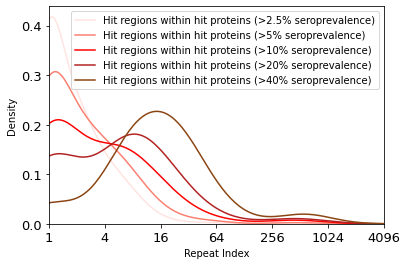

In [7]:

from matplotlib import pyplot as plt 
import seaborn as sns 

Z = df_peptide_fasta_HIT_peptides_sero2o5_groupedby_maxkmer['max_freq'] 
A = df_peptide_fasta_HIT_peptides_sero5_groupedby_maxkmer['max_freq']
B = df_peptide_fasta_HIT_peptides_sero10_groupedby_maxkmer['max_freq']
D = df_peptide_fasta_HIT_peptides_sero20_groupedby_maxkmer['max_freq']
F = df_peptide_fasta_HIT_peptides_sero40_groupedby_maxkmer['max_freq']

import numpy as np 
fig, ax = plt.subplots()
sns.kdeplot(np.log2(Z),color='mistyrose',bw=0.5,label='Hit regions within hit proteins (>2.5% seroprevalence)')
sns.kdeplot(np.log2(A),color='salmon',bw=0.5,label='Hit regions within hit proteins (>5% seroprevalence)')
sns.kdeplot(np.log2(B),color='red',bw=0.5,label='Hit regions within hit proteins (>10% seroprevalence)')
sns.kdeplot(np.log2(D),color='firebrick',bw=0.5,label='Hit regions within hit proteins (>20% seroprevalence)')
sns.kdeplot(np.log2(F),color='saddlebrown',bw=0.5,label='Hit regions within hit proteins (>40% seroprevalence)')
ax.tick_params(labelsize =13)
ax.set_xlim(0,12)
ax.set_xticklabels(['1','4','16','64','256','1024','4096','16384'],size=13)
ax.set_xlabel('Repeat Index')
plt.legend( loc='upper right',prop={'size': 10})


## comparing hit peptides with non-hit peptides in hit proteins 

In [ ]:

### Comparing the distribution of kmer frequency in the HIT set vs random sampling of  non-hit peptides from hit proteins

import seaborn as sns 

Z = df_peptide_fasta_HIT_peptides_sero2o5_groupedby_maxkmer['max_freq'] 
A = df_peptide_fasta_HIT_peptides_sero5_groupedby_maxkmer['max_freq']
B = df_peptide_fasta_HIT_peptides_sero10_groupedby_maxkmer['max_freq']
D = df_peptide_fasta_HIT_peptides_sero20_groupedby_maxkmer['max_freq']
F = df_peptide_fasta_HIT_peptides_sero40_groupedby_maxkmer['max_freq']

df_peptide_fasta_NON_HIT_peptides_HITproteins = pd.read_csv('Nonhit_peptides_hit_proteins_withrepeatinfo_7mer_conservativesubs.csv',header=0,index_col=0)

Z_random = df_peptide_fasta_NON_HIT_peptides_HITproteins.sample(n=3107,random_state=11)['max_freq']
A_random = df_peptide_fasta_NON_HIT_peptides_HITproteins.sample(n=827,random_state=11)['max_freq']
B_random = df_peptide_fasta_NON_HIT_peptides_HITproteins.sample(n=219,random_state=11)['max_freq']
D_random = df_peptide_fasta_NON_HIT_peptides_HITproteins.sample(n=73,random_state=11)['max_freq']
F_random = df_peptide_fasta_NON_HIT_peptides_HITproteins.sample(n=21,random_state=12)['max_freq']

import numpy as np 
fig, ax = plt.subplots()
sns.kdeplot(np.log2(Z),color='mistyrose',bw=0.5,label='Hit regions within hit proteins (>2.5% seroprevalence)')
sns.kdeplot(np.log2(A),color='salmon',bw=0.5,label='Hit regions within hit proteins (>5% seroprevalence)')
sns.kdeplot(np.log2(B),color='red',bw=0.5,label='Hit regions within hit proteins (>10% seroprevalence)')
sns.kdeplot(np.log2(D),color='firebrick',bw=0.5,label='Hit regions within hit proteins (>20% seroprevalence)')
sns.kdeplot(np.log2(F),color='saddlebrown',bw=0.5,label='Hit regions within hit proteins (>40% seroprevalence)')
sns.kdeplot(np.log2(Z_random),color='grey',bw=0.5,label='Non-hit regions within hit proteins')
#ax.set_yscale('log')
#plt.hist(A_random,bins=40,color='grey', range=(0,130))
#ax.set_xscale('log',basex=2)
#ax.set_yscale('log',basey=2)
#ax.set_xlabel('Cumulative repeat frequency',size=15)
ax.tick_params(labelsize =13)
ax.set_xlim(0,12)
ax.set_xticklabels(['1','4','16','64','256','1024','4096','16384'],size=13)
ax.set_xlabel('Repeat Index')
plt.legend( loc='upper right',prop={'size': 10})
#plt.savefig('Fig4c.pdf', dpi=800)

plt.show()



## pvalue calculation for difference in distribution for 1000 random samplings 
import scipy
from decimal import Decimal
def pvalueboot(df,df_random,samplen):
    pvalues = []
    for i in range(0,1000):
        df_random_1491 = df_random.sample(n=samplen,random_state=i)

        X = df['max_freq']
        X_random = df_random_1491['max_freq']
        pvalues.append(scipy.stats.ks_2samp(X,X_random)[1])

    print (min(pvalues),(max(pvalues)))
    
    max_pvalue = '%.2E' % Decimal(str(max(pvalues)))
    return ('E' + max_pvalue.split("E")[1])

errors = []
errors.append(pvalueboot(df_peptide_fasta_HIT_peptides_sero2o5_groupedby_maxkmer,df_peptide_fasta_NON_HIT_peptides_HITproteins,samplen=3107))
errors.append(pvalueboot(df_peptide_fasta_HIT_peptides_sero5_groupedby_maxkmer,df_peptide_fasta_NON_HIT_peptides_HITproteins,samplen=827))
errors.append(pvalueboot(df_peptide_fasta_HIT_peptides_sero10_groupedby_maxkmer,df_peptide_fasta_NON_HIT_peptides_HITproteins,samplen=219))
errors.append(pvalueboot(df_peptide_fasta_HIT_peptides_sero20_groupedby_maxkmer,df_peptide_fasta_NON_HIT_peptides_HITproteins,samplen=73))
errors.append(pvalueboot(df_peptide_fasta_HIT_peptides_sero40_groupedby_maxkmer,df_peptide_fasta_NON_HIT_peptides_HITproteins,samplen=21))

print ('2.5% - 5% hit peptides ' + str(scipy.stats.ks_2samp(Z,A)[1]))
print ('5% - 10% hit peptides ' + str(scipy.stats.ks_2samp(A,B)[1]))
print ('10% - 20% hit peptides ' + str(scipy.stats.ks_2samp(B,D)[1]))
print ('20% - 40% hit peptides ' + str(scipy.stats.ks_2samp(D,F)[1]))


plt.savefig('Fig4c.pdf')



# Fig4d - Seroprevalence vs repeat index 

## Plot colormap for peptides based on repeat index for 9 antigens 




In [131]:
### Repeats with the highest seroprevalance 
 ## use the conservative substitution data 
    
temp2 = df_peptide_fasta
temp2['sero'] = df_peptide_fasta_HIT_peptides.filter(regex='CK3|CT3',axis=1).sum(axis=1)
temp2['sero'] = temp2['sero'].div(2) ### get seroprevalence % 
temp2 = temp2.fillna(0)
temp2.loc[df_peptide_fasta_HIT_peptides.index,'max_sevenmer'] = df_peptide_fasta_HIT_peptides['max_sevenmer']
temp2.loc[df_peptide_fasta_NON_HIT_peptides.index,'max_sevenmer'] = df_peptide_fasta_NON_HIT_peptides['max_sevenmer']
temp2.loc[df_peptide_fasta_HIT_peptides.index,'max_freq'] = df_peptide_fasta_HIT_peptides['max_freq']
temp2.loc[df_peptide_fasta_NON_HIT_peptides.index,'max_freq'] = df_peptide_fasta_NON_HIT_peptides['max_freq']


temp2.loc[temp2.filter(regex=r'PF3D7_0220000',axis=0).index,'gene'] = 'LSA3'

temp2.loc[temp2.filter(regex=r'PF3D7_0801000',axis=0).index,'gene'] = 'PHISTc'

temp2.loc[temp2.filter(regex=r'PF3D7_0501400',axis=0).index,'gene'] = 'FIRA'

temp2.loc[temp2.filter(regex=r'PF3D7_0935900',axis=0).index,'gene'] = 'REX1'

temp2.loc[temp2.filter(regex=r'PF3D7_1149000',axis=0).index,'gene'] = 'Ag332'

temp2.loc[temp2.filter(regex=r'PF3D7_1035300',axis=0).index,'gene'] = 'GLURP'

temp2.loc[temp2.filter(regex=r'PF3D7_0500800',axis=0).index,'gene'] = 'MESA'

temp2.loc[temp2.filter(regex=r'PF3D7_0201900',axis=0).index,'gene'] = 'EMP3'

temp2.loc[temp2.filter(regex=r'PF3D7_1036400',axis=0).index,'gene'] = 'LSA1'




/data/madhura/anaconda3/envs/phage/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/madhura/anaconda3/envs/phage/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/madhura/anaconda3/envs/phage/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/madhura/anaconda3/envs/phage/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/madhura/anaconda3/

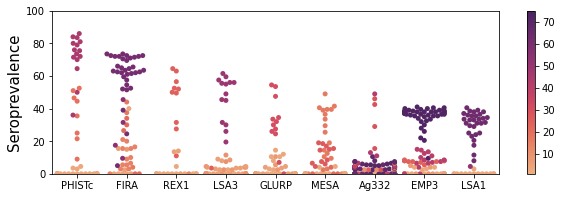

In [132]:
toplot = temp2.filter(regex=r'PF3D7_0220000|PF3D7_0801000|PF3D7_0501400|PF3D7_0935900|PF3D7_1149000|PF3D7_1035300|PF3D7_0500800|PF3D7_0201900|PF3D7_1036400',axis=0)

from matplotlib.colors import DivergingNorm
fig, ax = plt.subplots(figsize = (10,3))
norm = plt.Normalize(toplot['max_freq'].min(), toplot['max_freq'].max() )
sm = plt.cm.ScalarMappable(cmap="flare",norm=norm)
sm.set_array([])


sns.swarmplot(data=toplot, y = 'sero',x= 'gene',hue='max_freq',order = ['PHISTc','FIRA','REX1','LSA3','GLURP','MESA','Ag332','EMP3','LSA1'],palette='flare')
ax.set_ylabel('Seroprevalence',size=15)
ax.set_xlabel(' ')
ax.set_ylim(0,100)
ax.get_legend().remove()
ax.figure.colorbar(sm)
#plt.savefig('Fig4d.pdf')